In [1]:
import mhkit
from mhkit.wave import resource, performance, graphics
from sklearn.mixture import GaussianMixture
from mhkit.wave.io import ndbc
import matplotlib.pyplot as plt
from matplotlib import colors 
from scipy import stats
import pandas as pd
import numpy as np
import calendar
import os

## Import Data from NDBC

In [2]:
parameter = 'swden'
buoy_number = '46050' 
ndbc_available_data= ndbc.available_data(parameter, buoy_number)
years_of_interest = ndbc_available_data[ndbc_available_data.year < 2013]
filenames= years_of_interest['filename']
ndbc_requested_data = ndbc.request_data(parameter, filenames)

In [3]:
ndbc_data={}
# Create a Datetime Index and remove NOAA date columns for each year
for year in ndbc_requested_data:
    year_data = ndbc_requested_data[year]
    ndbc_data[year] = ndbc.to_datetime_index(parameter, year_data)

## Save 1-year of data for WecOptTool

Choose 1-year of data to perform analysis one and save full spectrum for use by WecOptTool

In [5]:
data_raw = ndbc_data['1996']
data_year = data_raw[data_raw != 999.0].dropna()

output_folder='ToWecOptTool'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

data_year.to_csv(os.path.join(output_folder,'46050_1996.csv'))

data_year

,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,...,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40
date,,,,,,,,,,,,,,,,,,,,,
1996-01-01 01:00:00,0.14,0.88,11.75,40.21,35.99,23.97,12.87,9.97,5.65,4.77,...,0.07,0.07,0.05,0.06,0.06,0.06,0.06,0.04,0.03,0.03
1996-01-01 02:00:00,0.11,0.46,6.73,22.24,22.54,17.98,15.50,10.37,9.44,7.20,...,0.11,0.11,0.07,0.08,0.07,0.05,0.06,0.04,0.03,0.02
1996-01-01 03:00:00,0.11,0.35,8.02,28.71,32.57,28.12,14.27,8.82,7.51,4.62,...,0.09,0.10,0.08,0.07,0.04,0.05,0.06,0.04,0.02,0.03
1996-01-01 04:00:00,0.08,0.42,6.34,18.72,20.53,23.50,15.63,9.24,7.60,4.42,...,0.13,0.07,0.09,0.10,0.06,0.05,0.04,0.03,0.03,0.03
1996-01-01 05:00:00,0.14,0.34,7.23,25.57,27.11,16.50,11.61,7.95,6.99,3.21,...,0.13,0.10,0.09,0.09,0.10,0.06,0.04,0.03,0.03,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996-08-21 18:00:00,0.01,0.00,0.03,0.11,0.28,0.44,1.37,2.28,2.54,1.94,...,0.03,0.03,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.02
1996-08-21 19:00:00,0.01,0.00,0.03,0.08,0.17,0.42,1.51,2.12,2.80,3.10,...,0.02,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.01
1996-08-21 20:00:00,0.01,0.00,0.03,0.08,0.19,0.50,1.25,1.46,1.33,1.95,...,0.02,0.02,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.01


## Calculate QoIs form Spectral Data

In [13]:
# Intialize empty lists to store the results from each year
Hm0_list=[]
Te_list=[]
J_list=[]
Tp_list=[]
Tz_list=[]

# Iterate over each year and save the result in the initalized dictionary
for year in ndbc_data:
    data_raw = ndbc_data[year]
    year_data = data_raw[data_raw != 999.0].dropna()
    Hm0_list.append(resource.significant_wave_height(year_data.T))
    Te_list.append(resource.energy_period(year_data.T))
    J_list.append(resource.energy_flux(year_data.T, h=399.))
    Tp_list.append(resource.peak_period(year_data.T))
    Tz_list.append(resource.average_zero_crossing_period(year_data.T))



    
# Concatenate list of Series into a single DataFrame
Te = pd.concat(Te_list ,axis=0)
Tp = pd.concat(Tp_list ,axis=0)
Hm0 = pd.concat(Hm0_list ,axis=0)
J = pd.concat(J_list ,axis=0)
Tz = pd.concat(Tz_list ,axis=0)
data = pd.concat([Hm0, Te, Tp, J, Sm],axis=1)

# Calculate wave steepness
data['Sm'] = data.Hm0 / (9.81/(2*np.pi) * data.Tz**2)

# Drop any NaNs created from the calculation of Hm0 or Te
data.dropna(inplace=True)
# Sort the DateTime index
data.sort_index(inplace=True)
data

C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **

,Hm0,Te,Tp,J,Tz,Sm
date,,,,,,
1996-01-01 01:00:00,5.215669,13.120481,16.666667,175221.249813,10.443476,0.030629
1996-01-01 02:00:00,4.582576,12.233122,14.285714,126091.304257,9.819304,0.030441
1996-01-01 03:00:00,4.968219,12.652905,14.285714,153262.455327,10.156357,0.030849
1996-01-01 04:00:00,4.432245,12.294969,12.500000,118538.780103,9.887688,0.029037
1996-01-01 05:00:00,4.425924,12.832110,14.285714,123386.849024,10.066949,0.027972
...,...,...,...,...,...,...
2012-12-31 19:00:00,2.955808,14.530107,17.391304,62281.560742,10.966684,0.015741
2012-12-31 20:00:00,2.626937,13.967092,17.391304,47278.147236,10.458411,0.015383
2012-12-31 21:00:00,2.826730,13.612849,16.000000,53345.280756,10.382509,0.016795


## Annual Scatter Table

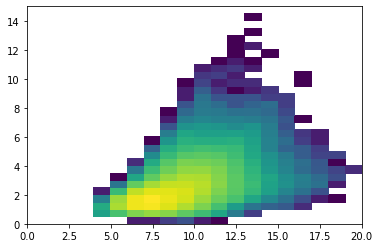

In [15]:
# Remove Hm0 Outliers
data_clean = data[data.Hm0 < 20]
sigma = data_clean.J.std()
data_clean = data_clean[data_clean.J > (data_clean.J.mean() - 0.9* sigma)]
#data_clean = data_clean[data_clean.J < data_clean.J.mean() + 3* data_clean.J.std()]

Hm0_bin_size = 0.5
Hm0_edges = np.arange(0,15+Hm0_bin_size,Hm0_bin_size)


Te_bin_size = 1
Te_edges = np.arange(0, 20+Te_bin_size,Te_bin_size)
Te_edges

h= plt.hist2d(data_clean.Te,  
              data_clean.Hm0, 
              bins = (Te_edges,Hm0_edges), 
              norm = colors.LogNorm())

## Wave Power by Month

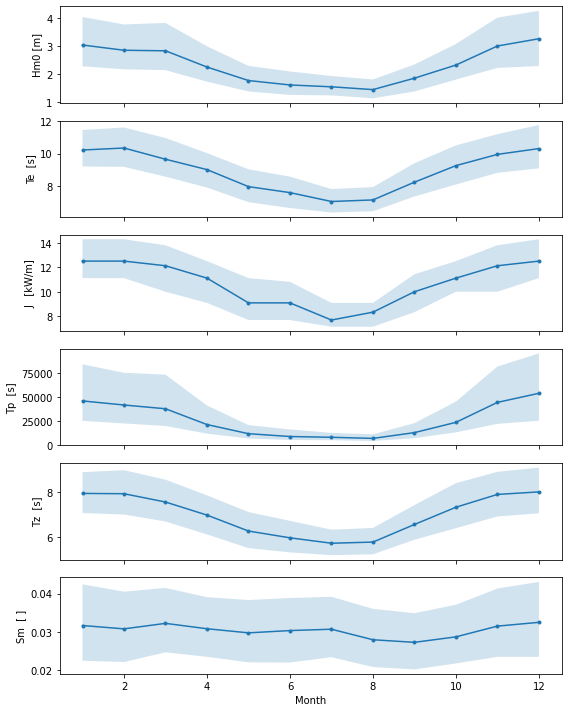

In [19]:
months=data_clean.index.month
data_group=data_clean.groupby(months)

QoIs = data_clean.keys()
fig, axs = plt.subplots(len(QoIs),1, figsize=(8, 10), sharex=True)
#shade between 25% and 75%
QoIs = data_clean.keys()
for i in range(len(QoIs)):
    QoI = QoIs[i]
    axs[i].plot(data_group.median()[QoI], marker='.')

    axs[i].fill_between(months.unique(),
                        data_group.describe()[QoI,   '25%'],
                        data_group.describe()[QoI,   '75%'],
                        alpha=0.2)

plt.setp(axs[5], xlabel='Month')
plt.setp(axs[0], ylabel='Hm0 [m]')

plt.setp(axs[1], ylabel='Te  [s]')
plt.setp(axs[2], ylabel='J   [kW/m]')
plt.setp(axs[3], ylabel='Tp  [s]')
plt.setp(axs[4], ylabel='Tz  [s]')
plt.setp(axs[5], ylabel='Sm  [ ]')


plt.tight_layout()

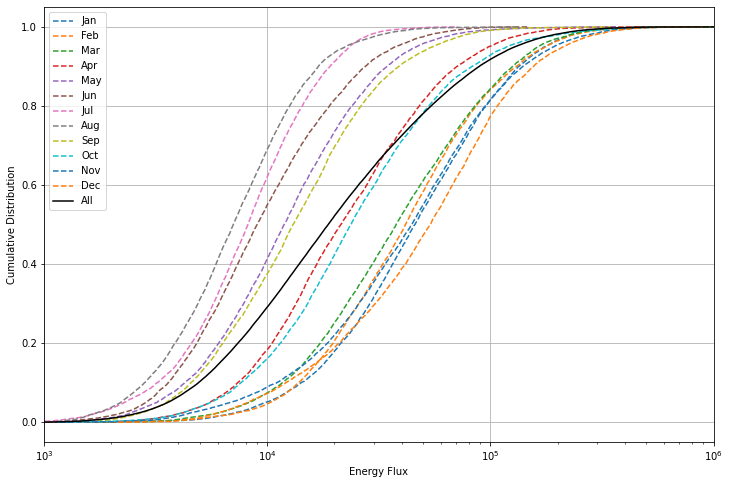

In [9]:
cumSum={}
for month in data_clean.index.month.unique():    
    F = mhkit.river.resource.exceedance_probability(data_clean[data_clean.index.month==month].J)
    cumSum[month] = 1-F/100
    cumSum[month].sort_values('F', inplace=True)
plt.figure(figsize=(12,8) )
for month in data_clean.index.month.unique():
    plt.semilogx(data_clean.loc[cumSum[month].index].J, cumSum[month].F, '--', label=calendar.month_abbr[month])

F = mhkit.river.resource.exceedance_probability(data_clean.J)
F.sort_values('F', inplace=True)
plt.semilogx(data_clean.loc[F.index].J, 1-F/100, 'k-', fillstyle='none', label='All')

plt.xlim([1000, 1E6])    
plt.grid()
plt.xlabel('Energy Flux')
plt.ylabel('Cumulative Distribution')
plt.legend()

## Calculate Sea State Representative Clusters

[Text(0.5, 0, 'Sig. wave height, $Hm0$ [m')]

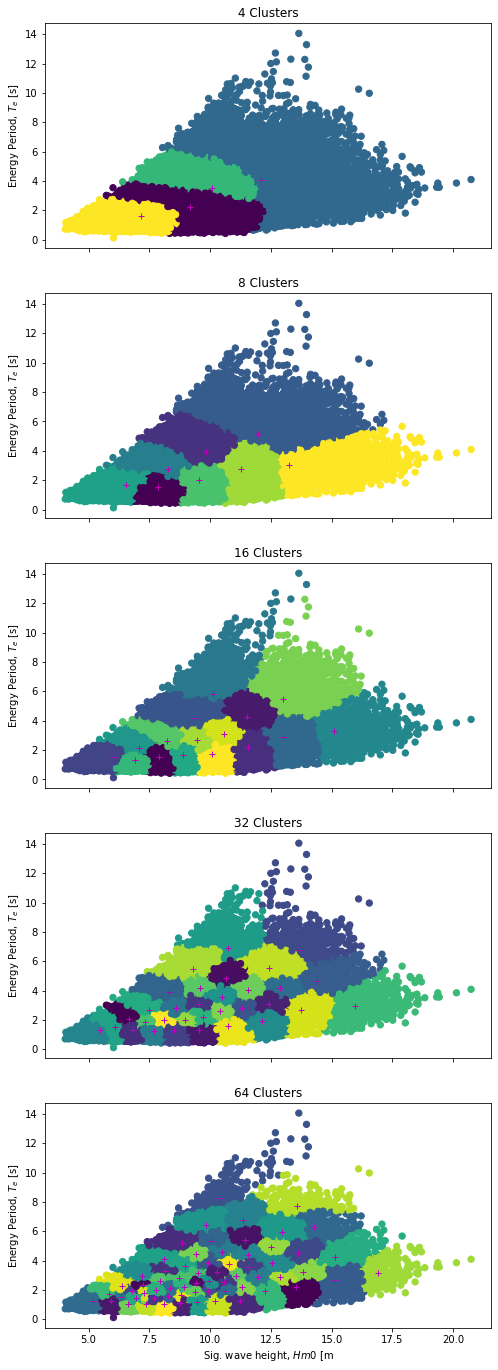

In [10]:
# Compute Gaussian Mixture Model for each number of clusters
Ns= [4, 8, 16, 32, 64]
X = np.vstack((data_clean.Te.values, data_clean.Hm0.values)).T
fig, axs = plt.subplots(len(Ns),1, figsize=(8, 24), sharex=True)

results={}
for N in Ns:
    gmm = GaussianMixture(n_components=N).fit(X)

    # Save centers and weights
    result = pd.DataFrame(gmm.means_, columns=['Te','Hm0'])
    result['weights'] = gmm.weights_

    result['Tp'] = result.Te / 0.858
    results[N] = result
    
    
    labels = gmm.predict(X)
    
    i = Ns.index(N)
    axs[i].scatter(data_clean.Te.values, data_clean.Hm0.values, c=labels, s=40)
    axs[i].plot(result.Te, result.Hm0, 'm+')
    axs[i].title.set_text(f'{N} Clusters')
    plt.setp(axs[i], ylabel='Energy Period, $T_e$ [s]')
plt.setp(axs[len(Ns)-1], xlabel='Sig. wave height, $Hm0$ [m')    

## Calculate Energy Flux

Calculate energy flux for each cluster and save results to file

In [11]:
w = ndbc_data[year].columns.values
f = w / 2*np.pi


for N in results:
    result = results[N]
    J=[]
    for i in range(len(result)):
        b = resource.bretschneider_spectrum(f, result.Tp[i], result.Hm0[i])
        J.extend([resource.energy_flux(b, h=399.).values[0][0]])
    
    result['J']  = J
    results[N] = result
    
    result.to_csv(f'toWecOpt\\{N}_cluster.csv', index=False)

C:\Users\sterl\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: 'toWecOpt\\4_cluster.csv'

In [ ]:
results[4]


## Plot Energy Flux Matrix

In [ ]:
Hm0_max=14
Te_max=16

reduce_factor=1

Hm0_bin_size = 0.5/reduce_factor
Te_bin_size = 1.0/reduce_factor

Hm0_bins = np.arange(0, Hm0_max + Hm0_bin_size, Hm0_bin_size)    
Te_bins = np.arange(0, Te_max + Te_bin_size, Te_bin_size)
#JM = mhkit.wave.performance.wave_energy_flux_matrix(data_clean.Hm0, data_clean.Te, data_clean.J, 'mean', Hm0_bins, Te_bins)
JM = performance.wave_energy_flux_matrix(data_clean.Hm0, data_clean.Te, data_clean.J, 'mean', Hm0_bins, Te_bins)


fig, ax = plt.subplots(figsize=(20, 10))
ax = graphics.plot_matrix(JM, ax=ax, show_values=False)
#L = mhkit.wave.performance.capture_length(P, data_clean.J) 

#maep_timeseries = mhkit.wave.performance.mean_annual_energy_production_timeseries(L, data_clean.J)
#print("MAEP from timeseries = ", maep_timeseries)

In [ ]:
Jmean, xe, ye, bn = stats.binned_statistic_2d(data_clean.Hm0, data_clean.Te, data_clean.J,
                                                  statistic='sum',bins=[Te_bins, Hm0_bins])
#H, xe,ye = np.histogram2d(data_clean.Hm0, data_clean.Te, bins=[Te_bins, Hm0_bins], density=True)

# Incident  Wave PowerResults

## Full Sea State


In [ ]:
nHours = (data_clean.index[1] - data_clean.index[0]).seconds/3600
Total = data_clean.J.sum() * nHours
print(f'{Total} (W*hr)/m')

## 2D Histogram Result

In [ ]:
x = Jmean.flatten() 
x = x[~np.isnan(x)]
hist_result = np.round(x.sum()/Total,4)
print(f'{hist_result} = (2D Histogram J) / (1-year total J) ')

## K-means

In [ ]:
ratios={}
for N in results:
    ratios[N] = np.round((results[N].J*len(data_clean)* results[N].weights).sum()/Total,4)
    
pd.Series(ratios)

In [ ]:
#MAP OF THE AREA
